In [2]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

sns.set_style('whitegrid')

sys.path.append("../")
from utility.ar1 import AR1
from utility.hmm1 import HMM1
from utility.ar import AR
from utility.hmmar1 import HMMAR1

In [49]:
# grouth truth
phi = 0.99
s = 1
v = s * (1 - phi**2)
w = s
hmm_sim = HMM1(phi, v, w_var=w)

# simulated series
np.random.seed(23502938)
df = hmm_sim.simulate(0, 1000)

# Fits a HMMRAR(1) model with known parameters
x0 = HMMAR1.LatentState(0, s)
para = HMMAR1.Parameter(phi, v, w)

hmm_model = HMMAR1(x0)

for y in df['ys']:
    hmm_model.filter(y, para)

<AxesSubplot: >

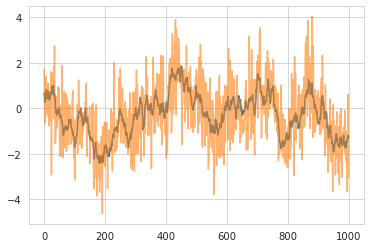

In [55]:
plt.plot(hmm_model.sample_trace(1, para).ravel()[1:])
df['ys'].plot(alpha=0.6)

In [153]:
from typing import NamedTuple

class PriorParameter(NamedTuple):
    # observation bias μ ~ N(g, G)
    mu0: float
    mu_var: float

    # observation variance 1/w ~ Ga(b/2, bw0/2)
    w0: float
    w_ddof: float

    # latent coef 𝛷 ~ N(c, C)I(|𝛷|<1)
    phi0: float
    phi_var: float

    # latent innovation 1/v ~ Ga(a/2, av0/2)
    v0: float
    v_ddof: float

priors = PriorParameter(
    mu0=0, mu_var=10, w0=w, w_ddof=9,
    phi0=0.7, phi_var=10, v0=1, v_ddof=9,
)

ys = df['ys'].values
para = HMMAR1.Parameter(phi, v, wt=w, bt=0, mu=0)
xs = hmm_model.sample_trace(1, para).ravel()
μ = np.random.normal(loc=priors.mu0, scale=np.sqrt(priors.mu_var))
𝛷 = stats.truncnorm.rvs(loc=priors.phi0, scale=np.sqrt(priors.phi_var), a=-1, b=1, size=None)
inv_w = np.random.gamma(shape=priors.w_ddof/2, scale=2/(priors.w_ddof*priors.w0))
inv_v = np.random.gamma(shape=priors.v_ddof/2, scale=2/(priors.v_ddof*priors.v0))

samples = []
for epoch in range(1000):
    # calcualte sufficient statistics
    n = xs.shape[0] - 1

    # gibbs sampler
    obs_error = (ys - xs[1:]).sum()
    μ = np.random.normal(
        loc=(priors.mu0*1/priors.mu_var + inv_w*obs_error)/(n*inv_w+1/priors.mu_var),
        scale=np.sqrt(1/(n*inv_w+1/priors.mu_var))
    )

    obs_square_error = (ys - (μ+xs[1:]))
    obs_square_error = obs_square_error @ obs_square_error
    inv_w = np.random.gamma(
        shape=(priors.w_ddof + n)/2,
        scale=2/(priors.w_ddof*priors.w0 + obs_square_error)
    )

    latent_square = xs[1:] @ xs[:-1]
    latent_prevsquare = xs[:-1] @ xs[:-1]
    𝛷 = stats.truncnorm.rvs(
        loc=(1/priors.phi_var*priors.phi0 + inv_v*latent_square)/(1/priors.phi_var + inv_v*latent_prevsquare),
        scale=np.sqrt(1/(1/priors.phi_var + inv_v*latent_prevsquare)),
        a=-1, b=1, size=None
    )

    latent_s = xs[1:] - 𝛷*xs[:-1]
    latent_s = latent_s @ latent_s
    inv_v = np.random.gamma(
        shape=(priors.v_ddof + n)/2,
        scale=2/(priors.v_ddof*priors.v0 + latent_s)
    )

    para = HMMAR1.Parameter(phi=𝛷, v=1/inv_v, wt=1/inv_w, bt=0, mu=μ)
    xs = hmm_model.sample_trace(1, para).ravel()

    # save sample
    samples.append((μ, inv_w, 𝛷, inv_v, xs))

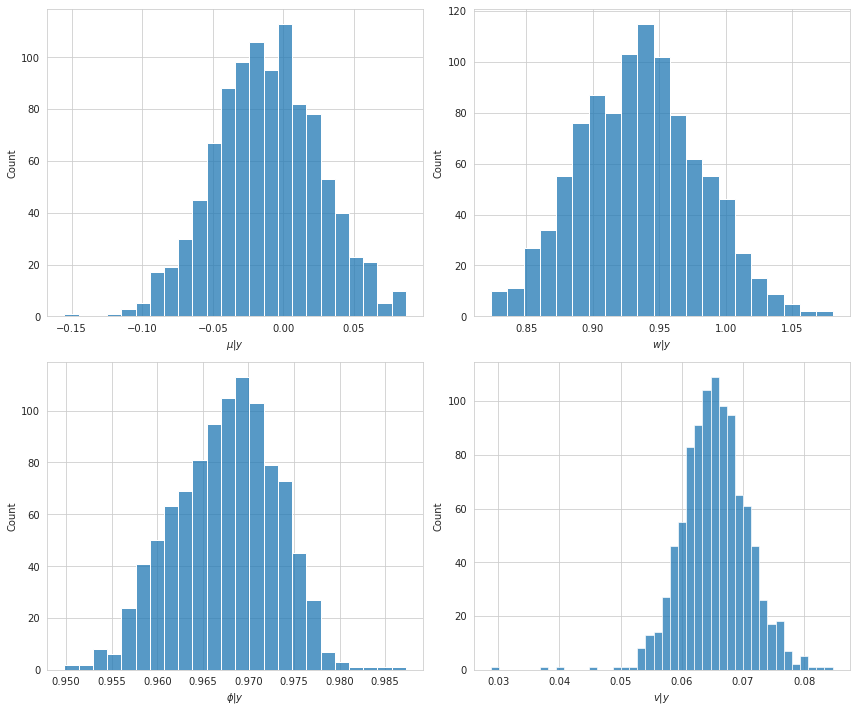

In [196]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sns.histplot(pd.Series(map(lambda x: x[0], samples)), ax=ax[0, 0])
sns.histplot(1/pd.Series(map(lambda x: x[1], samples)), ax=ax[0, 1])
sns.histplot(pd.Series(map(lambda x: x[2], samples)), ax=ax[1,0])
sns.histplot(1/pd.Series(map(lambda x: x[3], samples)), ax=ax[1, 1])

ax[0,0].set_xlabel('$\\mu|y$')
ax[0,1].set_xlabel('$w|y$')
ax[1,0].set_xlabel('$\\phi|y$')
ax[1,1].set_xlabel('$v|y$')

fig.tight_layout()
fig.show()

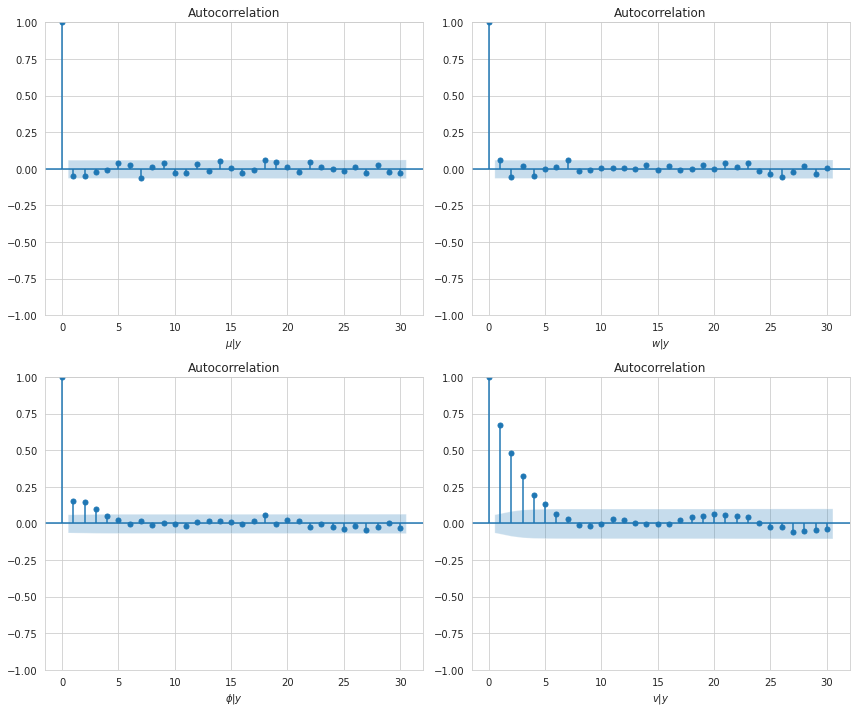

In [199]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[0], samples)), ax=ax[0,0])
sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[1], samples)), ax=ax[0,1])
sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[2], samples)), ax=ax[1,0])
sm.graphics.tsa.plot_acf(pd.Series(map(lambda x: x[3], samples)), ax=ax[1,1])

ax[0,0].set_xlabel('$\\mu|y$')
ax[0,1].set_xlabel('$w|y$')
ax[1,0].set_xlabel('$\\phi|y$')
ax[1,1].set_xlabel('$v|y$')

fig.tight_layout()
fig.show()

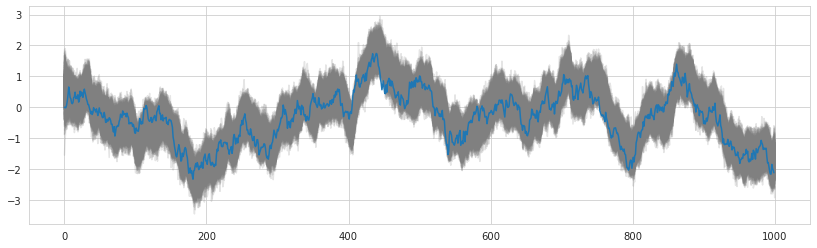

In [200]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.array(list(map(lambda x: x[4], samples))).T, alpha=0.2, color='grey')
ax.plot(df['xs'])